# Fuzzy Entropy

Similar to ApEn and SampEn, but employs the concept of fuzzy sets and retains superior good properties of SampEnt.

SampEn: Undefined when no template and forward match occurs.

Both ApEn and SampEn: similarity of vectors is based on Heaviside function where
<img src="images/pic8.jpg" width="600">

This results in a fixed boundary so an input pattern can only be considered belonging to a given class if it satisfies
some precise properties required of membership.

In the physical world, boundaries between classes may be ambiguous, so concept of "fuzzy sets" is used to introduce
"membership degree" with a fuzzy function $\mu_C(x)$ which associates each point x with a real number in range $[0,1]$.
So, the nearer the value of $\mu_C(x)$ to unity, the higher the membership grade of x in the set $C$.

In FuzzyEn, exponential function $exp(-(d^m_{ij})^n/r)$ used as fuzzy function to get fuzzy measurement of two vectors'
similarity based on their shapes.

Desired properties of exponential function:
- Being continuous so similarity does not change abruptly
- Being convex so self-similarity is the maximum

## Formula:

<img src="images/pic9.jpg" width="600">
<img src="images/pic10.jpg" width="600">

In [1]:
def complexity_embedding(signal, delay=1, dimension=2, show=False):
    N = len(signal)

    Y = np.zeros((dimension, N - (dimension - 1) * delay))
    for i in range(dimension):
        Y[i] = signal[i * delay : i * delay + Y.shape[1]]
    embedded = Y.T

    return embedded

def _get_count_fuzzy(embedded, r, distance="chebyshev", n=1):
    dist = sklearn.neighbors.DistanceMetric.get_metric(distance)
    dist = dist.pairwise(embedded)

    if n > 1:
        sim = np.exp(-(dist ** n) / r)
    else:
        sim = np.exp(-dist / r)
    # Return the count
    return np.sum(sim, axis=0)

def _get_embedded(signal, delay=1, dimension=2, r="default", distance="chebyshev"):
    # Get embedded
    embedded = complexity_embedding(signal, delay=delay, dimension=dimension)
    embedded = embedded[:-1]  # Removes the last line

    # FuzzyEn: Remove the local baselines of vectors
    embedded -= np.mean(embedded, axis=1, keepdims=True)
    count = _get_count_fuzzy(embedded, r=r, distance=distance, n=1)

    return embedded, count

def _get_r(signal, r="default", dimension=2):
    if isinstance(r, str) or (r is None):
        constant = 0.11604738531196232
        r = constant * np.std(signal, ddof=1) * (0.5627 * np.log(dimension) + 1.3334)

    return r

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.neighbors

Get series embeddings:

In [3]:
series = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
complexity_embedding(series, dimension=2)

array([[-0.5, -0.4],
       [-0.4, -0.3],
       [-0.3, -0.2],
       [-0.2, -0.1],
       [-0.1,  0. ],
       [ 0. ,  0.1],
       [ 0.1,  0.2],
       [ 0.2,  0.3],
       [ 0.3,  0.4],
       [ 0.4,  0.5]])

Get embedding with baseline removed and count similar vectors using fuzzy function:

In [4]:
r = _get_r(series)
_get_embedded(series, r=r)

(array([[-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05],
        [-0.05,  0.05]]),
 array([9., 9., 9., 9., 9., 9., 9., 9., 9.]))

In [5]:
def _phi(signal, delay=1, dimension=2, r="default", distance="chebyshev"):
    phi = np.zeros(2)

    embedded1, count1 = _get_embedded(
        signal, delay, dimension, r, distance=distance
    )

    embedded2, count2 = _get_embedded(signal, delay, dimension + 1, r, distance=distance)

    phi[0] = np.mean((count1 - 1) / (embedded1.shape[0] - 1))
    phi[1] = np.mean((count2 - 1) / (embedded2.shape[0] - 1))
    return phi


def _phi_divide(phi):
    if phi[0] == 0:
        return -np.inf
    division = np.divide(phi[1], phi[0])
    if division == 0:
        return np.inf
    return -np.log(division)

Get $\phi^m$ and $\phi^{m+1}$ and calculate fuzzy entropy

In [6]:
r = _get_r(series)
phi = _phi(series, delay=1, dimension=2, r=r)
fuzzy_entropy = _phi_divide(phi)
print("Fuzzy entropy: ", fuzzy_entropy)



Fuzzy entropy:  2.2204460492503136e-16


## Experiment:

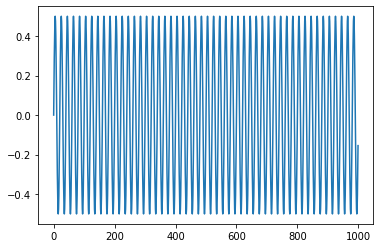

In [7]:
signal1 = nk.signal_simulate(duration=1, frequency=50)
plt.plot(signal1)

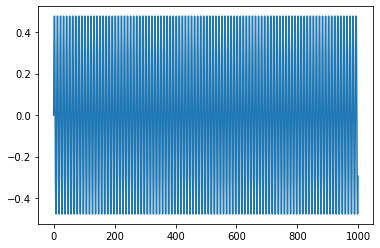

In [8]:
signal2 = nk.signal_simulate(duration=1, frequency=100)
plt.plot(signal2)

In [9]:
r_values = list(np.linspace(0.05, 1, num=20, endpoint=False))

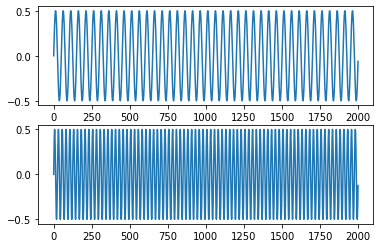

In [21]:
fig, axes = plt.subplots(2,1)
signal1 = nk.signal_simulate(duration=2, frequency=20)
axes[0].plot(pd.Series(signal1))
signal2 = nk.signal_simulate(duration=2, frequency=40)
axes[1].plot(pd.Series(signal2))

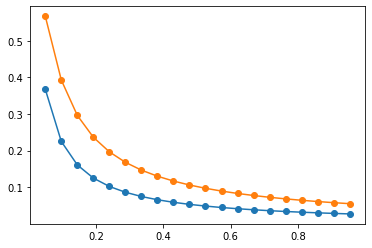

In [11]:
plt.plot(r_values, [nk.entropy_fuzzy(signal1[:50], r=r) for r in r_values], marker='o')
plt.plot(r_values, [nk.entropy_fuzzy(signal2[:50], r=r) for r in r_values], marker='o')


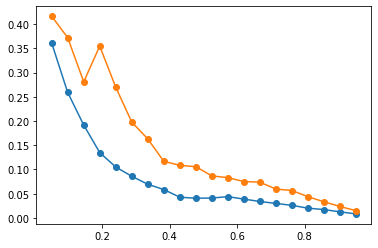

In [12]:
plt.plot(r_values, [nk.entropy_sample(signal1[:50], r=r) for r in r_values], marker='o')
plt.plot(r_values, [nk.entropy_sample(signal2[:50], r=r) for r in r_values], marker='o')

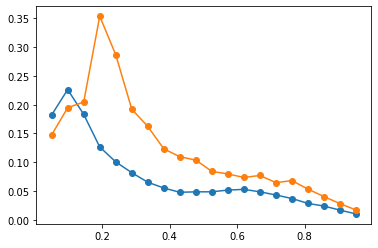

In [13]:
plt.plot(r_values, [nk.entropy_approximate(signal1[:50], r=r) for r in r_values], marker='o')
plt.plot(r_values, [nk.entropy_approximate(signal2[:50], r=r) for r in r_values], marker='o')

Observation: Fuzzy Entropy displays more relative consistency over different r values.

